# Incoherent-Excitation in Monomers
## Calculations for the paper: *sanity checks, convergence & analysis*

In [38]:
import time

from qutip import ket, mesolve, qeye, tensor, thermal_dm, destroy, steadystate
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi

import UD_liouv as RC
import driving_liouv as EM
import ME_checking as check
import exact_IB as exact
import scipy as sp

import phonon_weak_coupling as WC
from utils import J_overdamped, beta_f, J_underdamped, J_minimal_hard

reload(RC)
reload(EM)
reload(check)
reload(exact)
plt.style.use('ggplot')

Things to do in these notes:
- Convergence of RC theory with respect to N for increasing alpha:
    - a) Overdamped
    - b) Low and high-frequency under-damped
- Are all my overdamped parameters working correctly? Is $w_0 = \epsilon$ sufficient?
- I need to check that the exact solution gives me what I want: At which coupling strengths, mode frequencies, temperatures is the RC method valid?
- How about with underdamped modes?
- Look at vibronic/electronic eigenstate populations across windows of validity.
- Look at decay rates to various vibronic states when starting in various vibronic states
- check steadystate convergence with respect to $\omega_{RC}$ including optical driving at high T.
- check dynamics error with respect to $\omega_{RC}$ as well for low and high T.

Thus, does the ambiguity of $\omega_{RC}$ pose a major problem for incoherent excitation? *WHAT IS THE CORRECT APPROACH?!?!*
The non-RWA approach accounts for the fact that the environment plays a part in the transitions between eigenstates and does so in a way which preserves energy conservation, whilst also not discarding terms which are slowly oscillating.

- is it possible to find a variable which determines the validity of the RWA? : inversely proportional to $\alpha_{RC}$ (maybe this is only incidentally important as it's probably the population of the vibronic levels and whether the terms are near resonance).

For 02/02/2018. Write up the story so far:
- The phonon SD sharpness, coupling strength, temperature (and optical temperature) dependence of the validity of the quantum optical approximations.
- The ambiguity of $\omega_{RC}$ for overdamped spectral densities, what this means for vibronic and electronic dynamics. i.e.: electronic behaviour converges with $\omega_{RC}$ much faster than the vibronic for naive and full. **which is the best approach and why?**



In [39]:
# Things that will always be true
G = ket([0])
E = ket([1])
sigma = G*E.dag() # Definition of a sigma_- operator.
J_EM = EM.J_minimal
# Things that are true by default but are subject to overriding
## ~~ Parameters ~~

eps = 0.1*8065.5 # TLS splitting
#eps = 2.*1519.3 # ps
T_EM = 6000. # Optical bath temperature
#H_S = eps*E*E.dag()
#alpha_EM = 0.3 # System-bath strength (optical)
Gamma_EM = 0.1*5.309 #bare decay of electronic transition from inv. ps to in inv. cm
#Gamma_EM = 6.582E-7*1519.3
T_ph = 300. # Phonon bath temperature
overdamped = True
phonon_only = True
#fig1wc = 53.*0.188

''' RC stuff '''
N = 15
#w0 = 200.*0.188
Gamma = 60. # Width of distribution
alpha_ph = 3*eps # Ind.-Boson frame coupling
beta = beta_f(T_ph)#1/(0.695*T_ph)
wc = 1*53. # Ind.-Boson frame phonon cutoff freq
shift = 0.5*np.pi*alpha_ph
w0 = eps+50 #-100 # underdamped SD parameter omega_0
optical_cutoff = 20000.
if overdamped:
        Gamma = (w0**2)/wc
n_RC = EM.Occupation(w0, T_ph)
#initial_sys = G*G.dag()
#initial_sys = E*E.dag()
#initial_sys = 0.5*(G+E)*(E.dag()+G.dag())
initial_sys = 0.5*(E+G)*(E+G).dag()

rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
#print (rho_0*tensor(qeye(2), destroy(N).dag()*destroy(N))).tr()

# Expectation values and time increments needed to calculate the dynamics
expects_wc = [G*G.dag(), E*G.dag()]
expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag(), qeye(N)), 
           tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
           tensor(qeye(2), destroy(N).dag()+destroy(N))]
nTimeSteps = 250
timelist = np.linspace(0, 0.07, nTimeSteps)


def eigstate_calc_and_mag_sort(H, sort=True):
    # Helper function to calculate the eigenstates and sort
    # in order of eigvalue magnitude
    evals, evecs = H.eigenstates()
    if sort:
        evals, evecs = zip(*sorted(list(zip(evals, evecs)), key=lambda x: abs(x[0])))
    else:
        pass
    return np.array(evals), np.array(evecs)


## Convergence of spectral densities and dynamics

Firstly, with what values of $\omega_0$ does the overdamped limit of underdamped SD converge?



In [46]:

alpha_ph = 1*eps
nsteps = 1000
w = np.linspace(0., 3*eps, nsteps)
w0_i = 1.2*eps
w0_f = w0_i+2.5*eps
# total error is naturally a function of nsteps
total_error = np.sqrt(sum((J_underdamped(
                    w, 1*eps, w0_i**2/wc, w0_i)-J_underdamped(
                    w, 1*eps, w0_f**2/wc, w0_f))**2))
print "Average SD error per step: {}".format(total_error/nsteps)

opts = qt.Options(nsteps=5000)

Gamma_i = w0_i**2/wc
L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma_i, w0_i, alpha_ph, N)
DATA_sc_i =  np.array(mesolve(H_RC, rho_0, timelist, [L_RC], expects, progress_bar=True).expect[1])

Gamma_f = w0_f**2/wc
L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma_f, w0_f, alpha_ph, N)
DATA_sc_f =  np.array(mesolve(H_RC, rho_0, timelist, [L_RC], expects, progress_bar=True, options=opts).expect[1])

total_error_dyn = np.sqrt(abs(sum(DATA_sc_i-DATA_sc_f)**2))
print "Average (approx.) error in each timestep: {}".format(total_error_dyn/float(nTimeSteps))

Average SD error per step: 0.0131119193741
w_RC= 967.86  TLS splitting = 806.55 RC-res. bath coupling= 2.90640949473  N= 15 TLS-RC coupling= 1107.3422158 Gamma_RC=  17674.5845208
10.0%. Run time:   0.57s. Est. time left: 00:00:00:05
20.0%. Run time:   1.20s. Est. time left: 00:00:00:04
30.0%. Run time:   1.77s. Est. time left: 00:00:00:04
40.0%. Run time:   2.33s. Est. time left: 00:00:00:03
50.0%. Run time:   2.89s. Est. time left: 00:00:00:02
60.0%. Run time:   3.45s. Est. time left: 00:00:00:02
70.0%. Run time:   4.02s. Est. time left: 00:00:00:01
80.0%. Run time:   4.58s. Est. time left: 00:00:00:01
90.0%. Run time:   5.14s. Est. time left: 00:00:00:00
Total run time:   5.69s
w_RC= 2984.235  TLS splitting = 806.55 RC-res. bath coupling= 8.96142927543  N= 15 TLS-RC coupling= 1944.4290286 Gamma_RC=  168031.293117
10.0%. Run time:   5.17s. Est. time left: 00:00:00:46
20.0%. Run time:  10.33s. Est. time left: 00:00:00:41
30.0%. Run time:  18.25s. Est. time left: 00:00:00:42
40.0%. Run 

THings seem to converge fairly well where $\omega_0>\epsilon$. The greater $\omega_0$ is, the longer the calculations take but (generally) fewer states are needed.

In [93]:
from driving_liouv import Occupation
from qutip import spre, spost, sprepost

def L_full_secular(H_vib, A, eps, Gamma, T, J, time_units='cm', silent=False):
    '''
    Initially assuming that the vibronic eigenstructure has no
    degeneracy and the secular approximation has been made
    '''
    ti = time.time()
    d = H_vib.shape[0]
    L = 0
    eVals, eVecs = H_vib.eigenstates()
    A_dag = A.dag()
    terms = 0
    for l in range(int(d)):
        for m in range(int(d)):
            for p in range(int(d)):
                for q in range(int(d)):
                    secular_freq = (eVals[l]-eVals[m]) - (eVals[p]-eVals[q])
                    if abs(secular_freq) <1E-10:
                        terms+=1
                        A_lm = A.matrix_element(eVecs[l].dag(), eVecs[m])
                        A_lm_star = A_dag.matrix_element(eVecs[m].dag(), eVecs[l])
                        A_pq = A.matrix_element(eVecs[p].dag(), eVecs[q])
                        A_pq_star = A_dag.matrix_element(eVecs[q].dag(), eVecs[p])
                        coeff_1 = A_lm*A_pq_star
                        coeff_2 = A_lm_star*A_pq
                        eps_pq = abs(eVals[p]-eVals[q])
                        Occ = Occupation(eps_pq, T, time_units)
                        r_up = np.pi*J(eps_pq, Gamma, eps)*Occ
                        r_down = np.pi*J(eps_pq, Gamma, eps)*(Occ+1)
                        LM = eVecs[l]*eVecs[m].dag()
                        ML = LM.dag()
                        PQ = eVecs[p]*eVecs[q].dag()
                        QP = PQ.dag()
                        """
                        if abs(secular_freq) !=0:
                            print (abs(secular_freq), r_up, A_lm, A_lm_star, 
                                   A_pq, A_pq_star, r_down, l,m,p,q, m==q, l==p)
                        """
                        if abs(r_up*coeff_1)>0:
                            L+= r_up*coeff_1*(spre(LM*QP)-sprepost(QP,LM))
                        if abs(r_up*coeff_2)>0:
                            L+= r_up*coeff_2*(spost(PQ*ML)- sprepost(ML,PQ))
                        if abs(r_down*coeff_1)>0:
                            L+= r_down*coeff_1*(spre(ML*PQ)-sprepost(PQ, ML))
                        if abs(r_down*coeff_2)>0:
                            L+= r_down*coeff_2*(spost(QP*LM)-sprepost(LM, QP))
    if not silent:
        print "It took ", time.time()-ti, " seconds to build the secular Liouvillian"
        print "Secular approximation kept {:0.2f}% of total ME terms. \n".format(100*float(terms)/(d*d*d*d))
    return -L
w0=eps*0.3
Gamma = (w0**2)/wc
L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 10)
L_test1 = L_full_secular(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)
L_test2 = EM.L_vib_lindblad(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)

L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 20)
L_test1 = L_full_secular(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)
L_test2 = EM.L_vib_lindblad(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)

L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 30)
L_test1 = L_full_secular(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)
L_test2 = EM.L_vib_lindblad(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)

L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, 40)
L_test1 = L_full_secular(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)
L_test2 = EM.L_vib_lindblad(H_RC, A_EM_, eps, Gamma_EM, 6000., J_EM, time_units='cm', silent=False)
ss1 = steadystate(H_RC, [L_RC+L_test1]).ptrace(0)
ss2 = steadystate(H_RC, [L_RC+L_test2]).ptrace(0)
print ss1, ss2

w_RC= 241.965  TLS splitting = 806.55 RC-res. bath coupling= 0.726602373684  N= 10 TLS-RC coupling= 958.986489565 Gamma_RC=  1104.66153255
It took  1.44352602959  seconds to build the secular Liouvillian
Secular approximation kept 0.79% of total ME terms. 

It took  0.449676036835  seconds to build the vibronic Lindblad Liouvillian
w_RC= 241.965  TLS splitting = 806.55 RC-res. bath coupling= 0.726602373684  N= 20 TLS-RC coupling= 958.986489565 Gamma_RC=  1104.66153255
It took  10.2485909462  seconds to build the secular Liouvillian
Secular approximation kept 0.30% of total ME terms. 

It took  2.71664905548  seconds to build the vibronic Lindblad Liouvillian
w_RC= 241.965  TLS splitting = 806.55 RC-res. bath coupling= 0.726602373684  N= 30 TLS-RC coupling= 958.986489565 Gamma_RC=  1104.66153255
It took  43.2014839649  seconds to build the secular Liouvillian
Secular approximation kept 0.18% of total ME terms. 

It took  16.0299339294  seconds to build the vibronic Lindblad Liouvillian


**So we can see that** the two approaches give the same results. This is because the terms which are discarded when there are resonances (but $l\neq p$ and $m\neq q$) are forbidden due to the symmetry of the system operator and the vibronic Hamiltonian. This occurs when the terms describe EM-field-induced transitions between vibronic states on the same manifold, which are forbidden. We can also see that the more complete version takes considerably longer, however, with higher N, proportionally fewer terms are kept after the secular approximation.

## Convergence of RC theory dynamics (wrt N)
For some fairly strong coupling, when do the calculations stop changing appreciably with increasing N?

In [117]:
wc

53.0

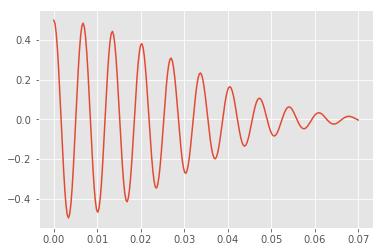

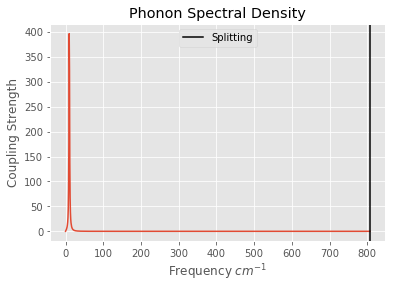

w_RC= 10.0  TLS splitting = 806.55 RC-res. bath coupling= 0.0300292345456  N= 3 TLS-RC coupling= 35.5939008452 Gamma_RC=  1.88679245283
	 ** Error:  2270.84899969  ** Took: 0.0476019382477s**
w_RC= 10.0  TLS splitting = 806.55 RC-res. bath coupling= 0.0300292345456  N= 4 TLS-RC coupling= 35.5939008452 Gamma_RC=  1.88679245283
	 ** Error:  2.04380475305  ** Took: 0.0621838569641s**
w_RC= 10.0  TLS splitting = 806.55 RC-res. bath coupling= 0.0300292345456  N= 5 TLS-RC coupling= 35.5939008452 Gamma_RC=  1.88679245283
	 ** Error:  0.12286756731  ** Took: 0.0770859718323s**
w_RC= 10.0  TLS splitting = 806.55 RC-res. bath coupling= 0.0300292345456  N= 6 TLS-RC coupling= 35.5939008452 Gamma_RC=  1.88679245283
	 ** Error:  0.00645055097341  ** Took: 0.142692089081s**
w_RC= 10.0  TLS splitting = 806.55 RC-res. bath coupling= 0.0300292345456  N= 7 TLS-RC coupling= 35.5939008452 Gamma_RC=  1.88679245283
	 ** Error:  0.00027224723239  ** Took: 0.191801071167s**
w_RC= 10.0  TLS splitting = 806.55 R

In [120]:

def integers(ni = 2, step=1):
    i = ni
    while True:
        i+=step
        yield i


def convergence_checker(alpha_prop, w0_prop, Gamma_, overdamped=False, threshold=10E-8):
    N_gen = integers()
    last_rc_sol = np.array([1])
    current_rc_sol = np.array([3])
    alpha_ph = eps*alpha_prop
    shift = 0.5*np.pi*alpha_ph
    w0 = eps*w0_prop
    if overdamped:
        Gamma_ = (w0**2)/wc
    w = np.linspace(0., eps, 1000)
    plt.figure()
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma_, w0))
    plt.axvline(eps, label='Splitting',color='k')
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    
    while sum(abs(last_rc_sol - current_rc_sol)**2) >threshold:
        
        N = N_gen.next()
        rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
        #print (rho_0*tensor(qeye(2), destroy(N).dag()*destroy(N))).tr()

        # Expectation values and time increments needed to calculate the dynamics
        expects_wc = [G*G.dag(), E*G.dag()]
        expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag(), qeye(N)), 
               tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(N).dag()+destroy(N))]
        ti = time.time()
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma_1= RC.RC_function_UD(
                                                    sigma, eps, T_ph, Gamma_, 
                                                    w0, alpha_ph, N)
        DATA_sc =  np.array(mesolve(H_RC, rho_0, timelist, [L_RC], expects).expect[1])
        tf = time.time()
        last_rc_sol = np.array(current_rc_sol)
        current_rc_sol =  DATA_sc
        print '\t ** Error: ', sum(abs(
                last_rc_sol - current_rc_sol)**2), " ** Took: {}s**".format(tf-ti)
    plt.plot(timelist, DATA_sc)
    plt.show()
convergence_checker(0.1, 10./eps, 0., overdamped=True, threshold=10E-8)
#convergence_checker(1., 1./14., 30., threshold=10E-6)
#convergence_checker(1., 1./2, 30., threshold=10E-6)

#convergence_checker(1., 1., 0, overdamped=True, threshold=10E-6)
#convergence_checker(1., 1.5, 0, overdamped=True, threshold=10E-6)

Underdamped:
- $\alpha=\epsilon$, $\omega_0=\epsilon/14, \Gamma=30cm^{-1}$ : converges at N=27 in 2.73s
- $\alpha=\epsilon$, $\omega_0=\epsilon/2, \Gamma=30cm^{-1}$ : converges at N=23 in 2.40s

Overdamped:
- $\alpha=\epsilon$, $\omega_0=1.5\epsilon, \Gamma=12274cm^{-1}$ : converges at N=16 in 6.6s
- $\alpha=\epsilon$, $\omega_0=2\epsilon, \Gamma=27617cm^{-1}$ : converges at N=15 in 9.17s

where $\Gamma$ is the width of the Lorentzian spectral density.

## Comparison to exact solution

How well does the RC theory agree with exact?
- w_0 dependence
- alpha dependence

300.0
30


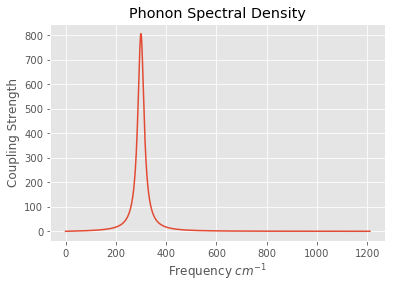

Exact solution 57.143 percent finished
Exact dynamics calculated
Exact solution took 4.36759209633 seconds.
w_RC= 300.0  TLS splitting = 806.55 RC-res. bath coupling= 0.0159154943092  N= 30 TLS-RC coupling= 194.955824025 Gamma_RC=  30


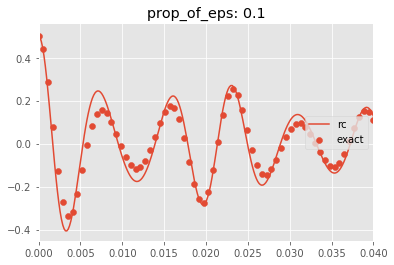

In [139]:
def exact_comparison_alpha(w0_prop, Gamma_, N=3, overdamped=False, T_ph=300.):
    timelist_exact = np.linspace(0, 0.04, 70)
    timelist = np.linspace(0, 0.04, 250)
    w0 = eps*w0_prop
    if overdamped:
        Gamma_ = (w0**2)/wc
    w = np.linspace(0., eps*1.5, 1000)
    print w0
    print Gamma_
    plt.figure()
    alpha_ph = 0.1*eps
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma_, w0))
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    plt.show()
    
    exact_sol = []
    rc_sol = []
    prop_of_eps = np.linspace(0.1,1,3)
    for prop in prop_of_eps:
        # how well
        alpha = prop*eps
        beta = beta_f(T_ph)#1/(0.695*T_ph)
        ti = time.time()
        rho_01 = np.array(exact.exact_dynamics(eps-0.5*alpha*pi, alpha, wc, 
                                               w0, Gamma_, beta, initial_sys, 
                                               timelist_exact, overdamped=overdamped))
        print "Exact dynamics calculated"
        print "Exact solution took {} seconds.".format(time.time()-ti)
        expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag(), qeye(N)), 
               tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(N).dag()+destroy(N))]
        rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
        #DATA_wc = mesolve(H_S, initial_sys, timelist, [L_wc], expects_wc, progress_bar=True)
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                       T_ph, Gamma_, 
                                                                       w0, alpha, N)
        #print H_RC.eigenenergies()
        #print eps-0.5*np.pi*alpha, eps+w0, eps-0.5*np.pi*alpha+w0
        DATA_sc = mesolve(H_RC, rho_0, timelist, [L_RC], expects).expect[1].real
        #exact_sol.append(rho_01.real)
        #rc_sol.append(DATA_sc.real)
        plt.figure()
        plt.title("prop_of_eps: {}".format(prop))
        plt.scatter(timelist_exact, rho_01, label="exact")
        plt.plot(timelist, DATA_sc, label="rc")
        plt.xlim(0,timelist[-1])
        # Everything is oscillating at the shifted frequency
        #plt.plot(timelist, 0.5*np.exp((-50.-1j*(eps-shift))*timelist))  
        plt.legend(loc='right')
        plt.show()
        break
exact_comparison_alpha(300./eps, 30, N=30, overdamped=False)

#exact_comparison_alpha(1.1, 0, N=18, overdamped=True)
#exact_comparison_alpha(1.1, 0, N=18,T_ph=80., overdamped=True)
#exact_comparison_alpha(0.4, 0, N=19,T_ph=300., overdamped=True)
#exact_comparison_alpha(0.4, ((0.4*eps)**2)/wc, N=19,T_ph=300., overdamped=False)
#exact_comparison_alpha(1.1, 0, N=18,T_ph=1000., overdamped=True)
#exact_comparison_alpha(1.2, 20, N=24, overdamped=False)
#exact_comparison_alpha(1./2., 20, N=24, overdamped=False)
#exact_comparison_alpha(1./5., 20, N=27, overdamped=False)

#

#exact_comparison_alpha(1., 0., N=16, overdamped=True)
#exact_comparison_alpha(2., 0., N=15, overdamped=True)

So we can see that for broad overdamped environments the RC method works extremely well, however for more structured environments it doesn't match the exact solution.

## Convergence of optical driving code

Now we will check steadystate convergence with respect to N including optical driving.

In [9]:

#L_1, H_1, _, _, _, _, _= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, eps*0.5, 10) # E_e >0
#L_2, H_2, _, _, _, _, _= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, eps*0.8, 10) # E_e <0

w_RC= 57.6107142857  TLS splitting = 806.55 RC-res. bath coupling= 0.0828777832727  N= 3 TLS-RC coupling= 270.163837294 Gamma_RC=  30.0
Calculating non-RWA Liouvilliian took 0.040657043457 seconds.
It took  0.0362038612366  seconds to build the Non-secular RWA Liouvillian
It took  0.00285601615906  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 0.51347899437s**
w_RC= 57.6107142857  TLS splitting = 806.55 RC-res. bath coupling= 0.0828777832727  N= 4 TLS-RC coupling= 270.163837294 Gamma_RC=  30.0
Calculating non-RWA Liouvilliian took 0.0635089874268 seconds.
It took  0.0618109703064  seconds to build the Non-secular RWA Liouvillian
It took  0.00260376930237  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 0.204462051392s**
w_RC= 57.6107142857  TLS splitting = 806.55 RC-res. bath coupling= 0.0828777832727  N= 5 TLS-RC coupling= 270.163837294 Gamma_RC=  30.0
Calculating non-RWA Liouvilliian took 0.0857300758362 seconds.
It took  0.

/home/henry/anaconda2/envs/qutip/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


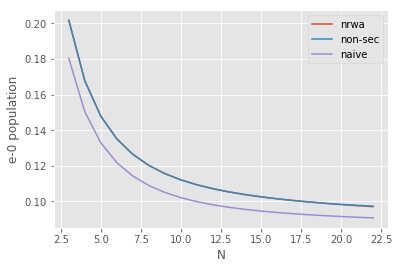

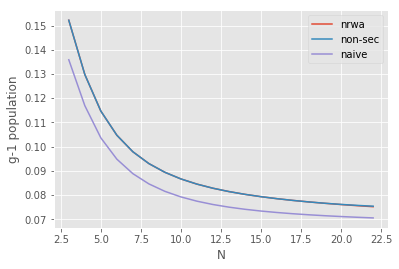

w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 3 TLS-RC coupling= 714.786326724 Gamma_RC=  30.0
Calculating non-RWA Liouvilliian took 0.0347309112549 seconds.
It took  0.0346632003784  seconds to build the Non-secular RWA Liouvillian
It took  0.00263094902039  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 0.1297352314s**
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 4 TLS-RC coupling= 714.786326724 Gamma_RC=  30.0
Calculating non-RWA Liouvilliian took 0.0626659393311 seconds.
It took  0.0601110458374  seconds to build the Non-secular RWA Liouvillian
It took  0.00260090827942  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 0.186096906662s**
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 5 TLS-RC coupling= 714.786326724 Gamma_RC=  30.0
Calculating non-RWA Liouvilliian took 0.0917639732361 seconds.
It took  0.0878100395203  sec

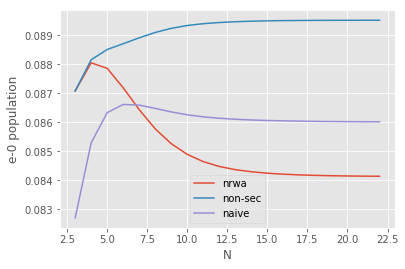

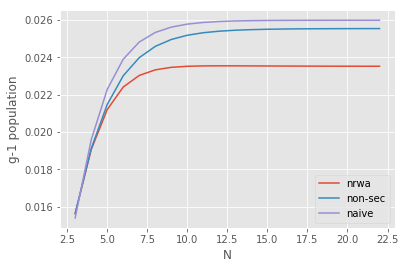

w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.46858498751  N= 3 TLS-RC coupling= 1010.86051745 Gamma_RC=  12510.0558173
Calculating non-RWA Liouvilliian took 0.0337588787079 seconds.
It took  0.0336120128632  seconds to build the Non-secular RWA Liouvillian
It took  0.0028338432312  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 0.130930185318s**
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.46858498751  N= 4 TLS-RC coupling= 1010.86051745 Gamma_RC=  12510.0558173
Calculating non-RWA Liouvilliian took 0.0672750473022 seconds.
It took  0.0597500801086  seconds to build the Non-secular RWA Liouvillian
It took  0.0026068687439  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 0.19011092186s**
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.46858498751  N= 5 TLS-RC coupling= 1010.86051745 Gamma_RC=  12510.0558173
Calculating non-RWA Liouvilliian took 0.0898430347443 seconds.
It took  0.0

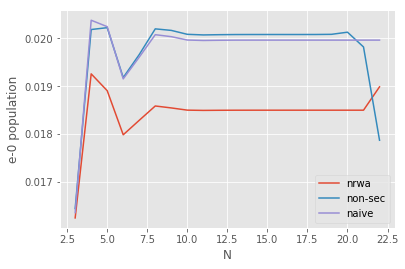

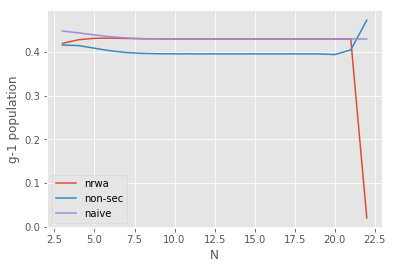

w_RC= 1209.825  TLS splitting = 806.55 RC-res. bath coupling= 3.70287748127  N= 3 TLS-RC coupling= 1238.04623444 Gamma_RC=  28147.6255889
Calculating non-RWA Liouvilliian took 0.0328030586243 seconds.
It took  0.0350630283356  seconds to build the Non-secular RWA Liouvillian
It took  0.00287818908691  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 0.146421194077s**
w_RC= 1209.825  TLS splitting = 806.55 RC-res. bath coupling= 3.70287748127  N= 4 TLS-RC coupling= 1238.04623444 Gamma_RC=  28147.6255889
Calculating non-RWA Liouvilliian took 0.152453899384 seconds.
It took  0.117812156677  seconds to build the Non-secular RWA Liouvillian
It took  0.00275778770447  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 0.394540071487s**
w_RC= 1209.825  TLS splitting = 806.55 RC-res. bath coupling= 3.70287748127  N= 5 TLS-RC coupling= 1238.04623444 Gamma_RC=  28147.6255889
Calculating non-RWA Liouvilliian took 0.130765914917 seconds.
It too

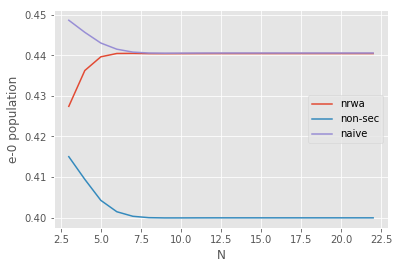

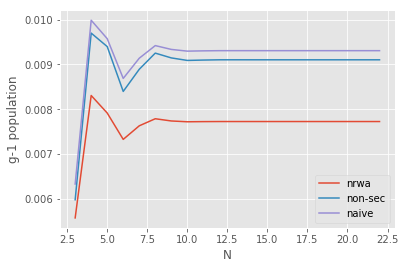

In [8]:
w0 = eps*1.1
wc = 52.
Gamma = (w0**2)/wc

def driving_convergence_N(alpha_prop, w0_prop, Gamma_, T_EM=6000., overdamped=False):
    e0_population = [[],[],[]]
    g1_population = [[],[],[]]
    labels = ['nrwa', 'non-sec', 'naive']
    alpha_ph = eps*alpha_prop
    shift = 0.5*np.pi*alpha_ph
    w0 = eps*w0_prop
    if overdamped:
        Gamma_ = (w0**2)/wc
    #w = np.linspace(0., eps, 1000)
    #plt.figure()
    #plt.plot(w, J_underdamped(w, alpha_ph, Gamma_, w0))
    #plt.axvline(eps-shift, label='Splitting',color='k')
    #plt.ylabel("Coupling Strength")
    #plt.xlabel(r"Frequency $cm^{-1}$")
    #plt.title("Phonon Spectral Density")
    #plt.legend()
    #plt.show()
    N_values = range(3,23)
    for n in N_values:
        rho_0 = tensor(initial_sys, thermal_dm(n, n_RC))
        #print (rho_0*tensor(qeye(2), destroy(N).dag()*destroy(N))).tr()

        # Expectation values and time increments needed to calculate the dynamics
        expects = [tensor(G*G.dag(), qeye(n)), tensor(E*G.dag(), qeye(n)), 
               tensor(E*E.dag(), qeye(n)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(n).dag()+destroy(n))]
        ti = time.time()
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma_1= RC.RC_function_UD(
                                                    sigma, eps, T_ph, Gamma_, 
                                                    w0, alpha_ph, n)
        evals, states = eigstate_calc_and_mag_sort(H_RC, sort=False)
        
        L= [EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM), 
            EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J_EM),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J_EM)]
        
        for j, L_EM in enumerate(L):
            state = states[1]
            e0_population[j].append(steadystate(H_RC, [L_RC+L_EM]).matrix_element(
                                                                state.dag(), state))
            state = states[2]
            g1_population[j].append(steadystate(H_RC, [L_RC+L_EM]).matrix_element(
                                                                state.dag(), state))
        tf = time.time()
        print " ** Steady states took: {}s**".format(tf-ti)
    plt.figure()
    for i in range(len(e0_population)):
        plt.ylabel('e-0 population')
        plt.xlabel('N')
        plt.plot(N_values, e0_population[i], label=labels[i])
        plt.legend()
    plt.figure()
    for i in range(len(g1_population)):
        plt.ylabel('g-1 population')
        plt.xlabel('N')
        plt.plot(N_values, g1_population[i], label=labels[i])
        plt.legend()
    plt.show()
driving_convergence_N(1., 1./14., 30.)
driving_convergence_N(1., 1./2, 30.)

driving_convergence_N(1., 1., 0, overdamped=True)
driving_convergence_N(1., 1.5, 0, overdamped=True)

Check convergence of decay rates with w0. With $\omega_0>\epsilon$ we hope to see the decay rates converge.

1
w_RC= 0.80655  TLS splitting = 806.55 RC-res. bath coupling= 0.00242200791228  N= 25 TLS-RC coupling= 12.3804623444 Gamma_RC=  0.0122740170283
Calculating non-RWA Liouvilliian took 1.45716309547 seconds.
It took  2.10884618759  seconds to build the Non-secular RWA Liouvillian
It took  8.82116985321  seconds to build the vibronic Lindblad Liouvillian
It took  0.00303602218628  seconds to build the electronic-Lindblad Liouvillian
2
w_RC= 99.5513142857  TLS splitting = 806.55 RC-res. bath coupling= 0.298944976601  N= 25 TLS-RC coupling= 137.544970595 Gamma_RC=  186.989890113
Calculating non-RWA Liouvilliian took 1.45087599754 seconds.
It took  1.9577331543  seconds to build the Non-secular RWA Liouvillian
It took  6.46495509148  seconds to build the vibronic Lindblad Liouvillian
It took  0.00312995910645  seconds to build the electronic-Lindblad Liouvillian
3
w_RC= 198.296078571  TLS splitting = 806.55 RC-res. bath coupling= 0.59546794529  N= 25 TLS-RC coupling= 194.123574107 Gamma_RC= 

Calculating non-RWA Liouvilliian took 0.440113067627 seconds.
It took  0.640366077423  seconds to build the Non-secular RWA Liouvillian
It took  1.04312992096  seconds to build the vibronic Lindblad Liouvillian
It took  0.0026388168335  seconds to build the electronic-Lindblad Liouvillian
21
w_RC= 1975.70183571  TLS splitting = 806.55 RC-res. bath coupling= 5.93288138169  N= 14 TLS-RC coupling= 612.748021304 Gamma_RC=  73649.014031
Calculating non-RWA Liouvilliian took 0.53672504425 seconds.
It took  0.687577009201  seconds to build the Non-secular RWA Liouvillian
It took  0.841938018799  seconds to build the vibronic Lindblad Liouvillian
It took  0.00273489952087  seconds to build the electronic-Lindblad Liouvillian
22
w_RC= 2074.4466  TLS splitting = 806.55 RC-res. bath coupling= 6.22940435038  N= 14 TLS-RC coupling= 627.873777681 Gamma_RC=  81194.8810614
Calculating non-RWA Liouvilliian took 0.500096082687 seconds.
It took  0.682786941528  seconds to build the Non-secular RWA Liouvi

Calculating non-RWA Liouvilliian took 0.443409919739 seconds.
It took  0.623904943466  seconds to build the Non-secular RWA Liouvillian
It took  0.817126989365  seconds to build the vibronic Lindblad Liouvillian
It took  0.00274205207825  seconds to build the electronic-Lindblad Liouvillian
40
w_RC= 3851.85235714  TLS splitting = 806.55 RC-res. bath coupling= 11.5668177868  N= 14 TLS-RC coupling= 855.570953391 Gamma_RC=  279938.992099
Calculating non-RWA Liouvilliian took 0.450671195984 seconds.
It took  0.621098041534  seconds to build the Non-secular RWA Liouvillian
It took  0.815014839172  seconds to build the vibronic Lindblad Liouvillian
It took  0.00262308120728  seconds to build the electronic-Lindblad Liouvillian
41
w_RC= 3950.59712143  TLS splitting = 806.55 RC-res. bath coupling= 11.8633407555  N= 14 TLS-RC coupling= 866.468117922 Gamma_RC=  294475.804072
Calculating non-RWA Liouvilliian took 0.448859930038 seconds.
It took  0.708120107651  seconds to build the Non-secular RW

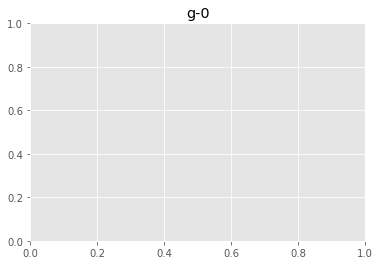

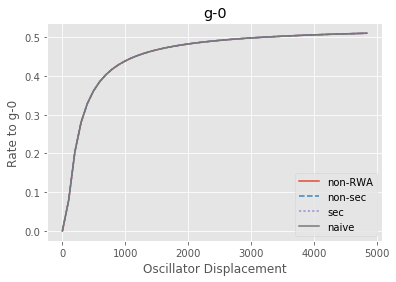

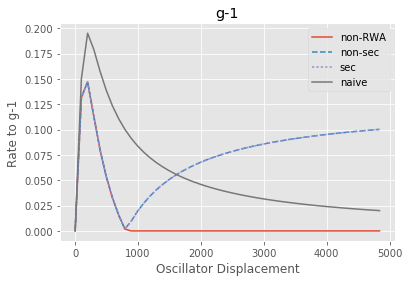

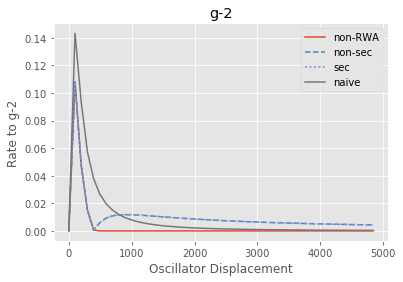

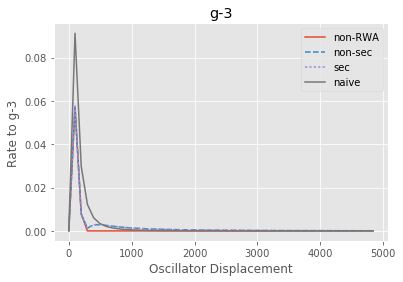

In [77]:
from qutip import vector_to_operator, operator_to_vector, basis


def decay_rate_wRC_dependence(eps, T_ph, alpha_ph, Gamma, T_EM=0., overdamped=True, nvib=3):
    omega_0_props = np.linspace(0.001, 6., 50)
    omega_0 = omega_0_props*eps
    #displacements = alpha_ph/w0
    N = 25
    
    decay_wrt_wRC = [[],[],[],[]]
    labels = ['g-0',  'g-1', 'g-2','g-3', 'g-4', 'g-5']
    count = 1
    for w0 in omega_0:
        if overdamped:
            Gamma = w0**2/wc
        else:
            Gamma = 60.
        print count 
        count+=1
        if w0 > eps*0.7:
            N = 14
        L_RC, H, A_EM, A_nrwa, wRC, kappa, Gamma_1 = RC.RC_function_UD(
                                            sigma, eps, T_ph, Gamma, w0, alpha_ph, N)
        
    # given some Liouvillian, find the instantaneous decay rates
    # from e-0 to the ground manifold eigenstates, for several
    # oscillator displacements
    # - need to find the first eigenstate in the excited manifold
        evals, states = eigstate_calc_and_mag_sort(H, sort=False)
        ground_list = []
        excited_list = []
        for i in range(len(evals)):
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        excited_ket = states[excited_list[0]]
        
        #initial_ket = tensor(basis(2,1), basis(N,0))
        excited_rho = excited_ket*excited_ket.dag()
        
        L= [EM.L_non_rwa(H, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM), 
            EM.L_nonsecular(H, A_EM, eps, Gamma_EM, T_EM, J=J_EM),
            EM.L_vib_lindblad(H, A_EM, eps, Gamma_EM, T_EM, J=J_EM),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J_EM)]
        for i_, L_EM in enumerate(L):
            decay_rates = [] # not really decay rates but population at short times
            for j in range(nvib):
                ground_ket = tensor(basis(2,0), basis(N,j))
                #print states[ground_list][j].dag()*target_ket
                #target_rho = operator_to_vector(target_ket*target_ket.dag())
                L_rho0_prod = vector_to_operator(L_EM*operator_to_vector(excited_ket*excited_ket.dag()))
                rate = L_rho0_prod.matrix_element(ground_ket.dag(), ground_ket)
                decay_rates.append(rate)
                
            if len(decay_rates)!=nvib:
                print ground_list
            decay_wrt_wRC[i_].append(decay_rates)
    for level in range(nvib): 
        plt.figure()
        plt.title(labels[level])
        plt.plot(omega_0_props, np.array(decay_wrt_wRC[0]).T[level], label='non-RWA')
        plt.plot(omega_0_props, np.array(decay_wrt_wRC[1]).T[level], label='non-sec', linestyle='dashed')
        plt.plot(omega_0_props, np.array(decay_wrt_wRC[2]).T[level], label='sec', linestyle='dotted')
        plt.plot(omega_0_props, np.array(decay_wrt_wRC[3]).T[level], label='naive')
        plt.legend()
        plt.xlabel(r'Oscillator Frequency (units of $\epsilon$)')
        plt.ylabel('Rate to {}'.format(labels[level]))
    plt.show()
    return displacements, decay_wrt_wRC
    #for i, alpha in enumerate(alpha_ph):
    #    plt.plot(decay_wrt_alpha[i])

displacements, decay_wrt_wRC = decay_rate_wRC_dependence(eps, 300., eps*0.15, 60., overdamped=True, nvib=4)
#decay_rate_plotter(H_RC, L_ns)
#decay_rate_plotter(H_RC, L_n)

## Steadystate convergence: $\omega_{RC}$ dependence
Now convergence of steadystates with respect to $\omega_{RC}$, since although the rates for lowest lying states (particularly for naive) are not converged well into $\omega_{RC}>\epsilon$, this may not affect the steady states. If so at high T, it might not at low T.

1
w_RC= 8.0655  TLS splitting = 806.55 RC-res. bath coupling= 0.0246858498751  N= 35 TLS-RC coupling= 55.36711079 Gamma_RC=  1.25100558173
Calculating non-RWA Liouvilliian took 4.78401303291 seconds.
It took  4.22359395027  seconds to build the Non-secular RWA Liouvillian
It took  0.00398993492126  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 14.6563961506s**
2
w_RC= 26.007122449  TLS splitting = 806.55 RC-res. bath coupling= 0.079599271026  N= 35 TLS-RC coupling= 99.4219701464 Gamma_RC=  13.0071234245
Calculating non-RWA Liouvilliian took 6.81033015251 seconds.
It took  4.3156440258  seconds to build the Non-secular RWA Liouvillian
It took  0.00414419174194  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 16.9046940804s**
3
w_RC= 43.948744898  TLS splitting = 806.55 RC-res. bath coupling= 0.134512692177  N= 35 TLS-RC coupling= 129.243720692 Gamma_RC=  37.1440803482
Calculating non-RWA Liouvilliian took 5.85958099365 seconds.

It took  2.22068810463  seconds to build the Non-secular RWA Liouvillian
It took  0.00437116622925  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 7.35012102127s**
22
w_RC= 384.839571429  TLS splitting = 806.55 RC-res. bath coupling= 1.17786769404  N= 25 TLS-RC coupling= 382.451241283 Gamma_RC=  2848.10568726
Calculating non-RWA Liouvilliian took 3.07604598999 seconds.
It took  2.29296517372  seconds to build the Non-secular RWA Liouvillian
It took  0.00363898277283  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 7.58721113205s**
23
w_RC= 402.781193878  TLS splitting = 806.55 RC-res. bath coupling= 1.23278111519  N= 25 TLS-RC coupling= 391.264824831 Gamma_RC=  3119.8594258
Calculating non-RWA Liouvilliian took 2.55682587624 seconds.
It took  2.75912714005  seconds to build the Non-secular RWA Liouvillian
It took  0.00640606880188  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 7.69116806984s**
24


Calculating non-RWA Liouvilliian took 0.680984973907 seconds.
It took  0.695849895477  seconds to build the Non-secular RWA Liouvillian
It took  0.00278806686401  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 2.11096906662s**
43
w_RC= 761.613642857  TLS splitting = 806.55 RC-res. bath coupling= 2.33104953821  N= 14 TLS-RC coupling= 538.026381287 Gamma_RC=  11154.9104036
Calculating non-RWA Liouvilliian took 0.806991815567 seconds.
It took  0.68187713623  seconds to build the Non-secular RWA Liouvillian
It took  0.00314998626709  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 2.09266614914s**
44
w_RC= 779.555265306  TLS splitting = 806.55 RC-res. bath coupling= 2.38596295936  N= 14 TLS-RC coupling= 544.326738413 Gamma_RC=  11686.6617628
Calculating non-RWA Liouvilliian took 0.691841125488 seconds.
It took  0.733360052109  seconds to build the Non-secular RWA Liouvillian
It took  0.00357294082642  seconds to build the electroni

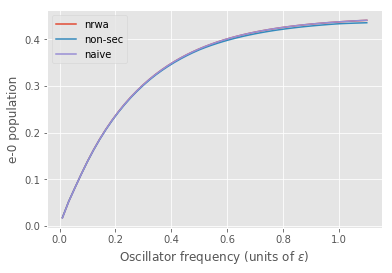

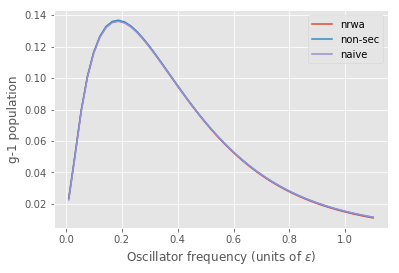

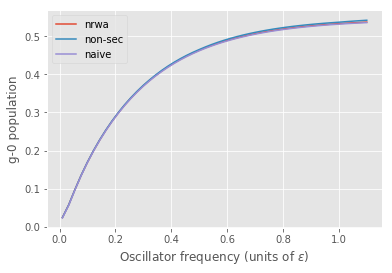

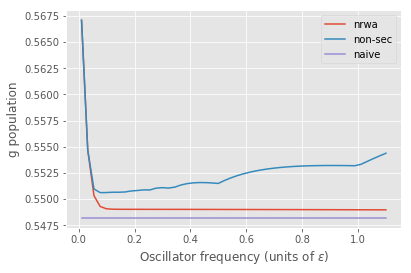

1
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.46858498751  N= 14 TLS-RC coupling= 553.6711079 Gamma_RC=  12510.0558173
Calculating non-RWA Liouvilliian took 0.702665805817 seconds.
It took  0.643187046051  seconds to build the Non-secular RWA Liouvillian
It took  0.00267887115479  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 2.01694107056s**
2
w_RC= 855.930612245  TLS splitting = 806.55 RC-res. bath coupling= 2.61972284389  N= 14 TLS-RC coupling= 570.368448364 Gamma_RC=  14088.7925573
Calculating non-RWA Liouvilliian took 0.773008108139 seconds.
It took  0.755186080933  seconds to build the Non-secular RWA Liouvillian
It took  0.00304889678955  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 2.19029808044s**
3
w_RC= 905.31122449  TLS splitting = 806.55 RC-res. bath coupling= 2.77086070027  N= 14 TLS-RC coupling= 586.590690393 Gamma_RC=  15761.3156382
Calculating non-RWA Liouvilliian took 0.668249845505 secon

It took  0.701684951782  seconds to build the Non-secular RWA Liouvillian
It took  0.00281810760498  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 2.12975883484s**
22
w_RC= 1843.54285714  TLS splitting = 806.55 RC-res. bath coupling= 5.64247997146  N= 14 TLS-RC coupling= 837.072034071 Gamma_RC=  65358.6589639
Calculating non-RWA Liouvilliian took 0.748281955719 seconds.
It took  0.771492004395  seconds to build the Non-secular RWA Liouvillian
It took  0.00273299217224  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 2.10880494118s**
23
w_RC= 1892.92346939  TLS splitting = 806.55 RC-res. bath coupling= 5.79361782784  N= 14 TLS-RC coupling= 848.208736922 Gamma_RC=  68906.9088646
Calculating non-RWA Liouvilliian took 0.608062028885 seconds.
It took  0.654474020004  seconds to build the Non-secular RWA Liouvillian
It took  0.0026650428772  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 1.83390593529s*

Calculating non-RWA Liouvilliian took 0.661612033844 seconds.
It took  1.00153684616  seconds to build the Non-secular RWA Liouvillian
It took  0.00268793106079  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 2.44151592255s**
43
w_RC= 2880.53571429  TLS splitting = 806.55 RC-res. bath coupling= 8.81637495541  N= 14 TLS-RC coupling= 1046.34004259 Gamma_RC=  159567.038486
Calculating non-RWA Liouvilliian took 0.638348817825 seconds.
It took  0.66309094429  seconds to build the Non-secular RWA Liouvillian
It took  0.00516200065613  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 1.9756860733s**
44
w_RC= 2929.91632653  TLS splitting = 806.55 RC-res. bath coupling= 8.96751281179  N= 14 TLS-RC coupling= 1055.27056052 Gamma_RC=  165084.801548
Calculating non-RWA Liouvilliian took 0.72479391098 seconds.
It took  0.724130868912  seconds to build the Non-secular RWA Liouvillian
It took  0.00274801254272  seconds to build the electronic-L

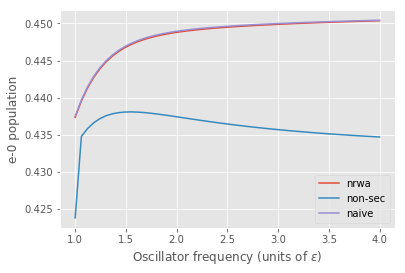

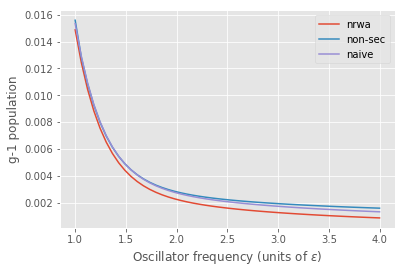

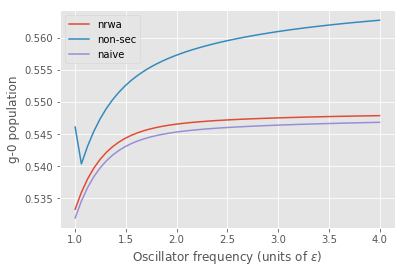

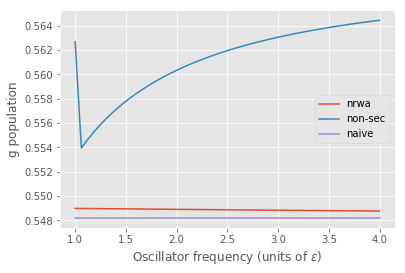

In [32]:
w0 = eps*1.1
wc = 52.
Gamma = (w0**2)/wc

def driving_convergence_wRC(eps, alpha_prop, T_EM=6000., T_ph=300., 
                            overdamped=False, min_w0_prop=0.01,
                            max_w0_prop=4.):
    omega_0_props = np.linspace(min_w0_prop, max_w0_prop, 50)
    omega_0 = omega_0_props*eps
    #displacements = alpha_ph/w0
    N = 35
    
    count = 1
    
    e0_population = [[],[],[]]
    g1_population = [[],[],[]]
    g0_population = [[],[],[]]
    g_total = [[],[],[]]
    labels = ['nrwa', 'non-sec', 'naive']
    alpha_ph = eps*alpha_prop
    shift = 0.5*np.pi*alpha_ph
    
    
    
    for w0 in omega_0:
        
        if overdamped:
            Gamma = w0**2/wc
        else:
            Gamma = 60.
        print count 
        count+=1

        if w0 > eps*0.2:
            N = 25
            if w0 > eps*0.7:
                N=14
        rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
        #print (rho_0*tensor(qeye(2), destroy(N).dag()*destroy(N))).tr()

        # Expectation values and time increments needed to calculate the dynamics
        expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag(), qeye(N)), 
               tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(N).dag()+destroy(N))]
        ti = time.time()
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma_1= RC.RC_function_UD(
                                                    sigma, eps, T_ph, Gamma, 
                                                    w0, alpha_ph, N)
        evals, states = H_RC.eigenstates()
        ground_list = []
        excited_list = []
        for i in range(len(evals)): #
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        L= [EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM), 
            EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J_EM),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J_EM)]
        
        for j, L_EM in enumerate(L):
            ss = steadystate(H_RC, [L_RC+L_EM])
            state = states[excited_list[0]]
            e0_population[j].append(ss.matrix_element(state.dag(), state))
            state = states[ground_list[1]]
            g1_population[j].append(ss.matrix_element(state.dag(), state))
            state = states[ground_list[0]]
            g0_population[j].append(ss.matrix_element(state.dag(), state))
            g_total[j].append((ss.ptrace(0)).matrix_element(G.dag(), G))
        tf = time.time()
        print " ** Steady states took: {}s**".format(tf-ti)
    plt.figure()
    for i in range(len(e0_population)):
        plt.ylabel('e-0 population')
        plt.xlabel(r'Oscillator frequency (units of $\epsilon$)')
        plt.plot(omega_0_props, e0_population[i], label=labels[i])
        plt.legend()
    plt.figure()
    for i in range(len(g1_population)):
        plt.ylabel('g-1 population')
        plt.xlabel(r'Oscillator frequency (units of $\epsilon$)')
        plt.plot(omega_0_props, g1_population[i], label=labels[i])
        plt.legend()
    plt.figure()
    for i in range(len(g0_population)):
        plt.ylabel('g-0 population')
        plt.xlabel(r'Oscillator frequency (units of $\epsilon$)')
        plt.plot(omega_0_props, g0_population[i], label=labels[i])
        plt.legend()
    plt.figure()
    for i in range(len(g0_population)):
        plt.ylabel('g population')
        plt.xlabel(r'Oscillator frequency (units of $\epsilon$)')
        plt.plot(omega_0_props, g_total[i], label=labels[i])
        plt.legend()
    plt.show()
    
    
#driving_convergence_wRC(eps, 0.3, T_EM=0., overdamped=True)
driving_convergence_wRC(eps, 0.3, T_EM=6000., max_w0_prop=1.1, overdamped=True)
driving_convergence_wRC(eps, 0.3, T_EM=6000., min_w0_prop=1, overdamped=True)

#driving_convergence_wRC(eps, 0.1, T_EM=6000., overdamped=True)

So we can see that the non-secular theory predicts steadystates which are very sensitive to $\omega_{RC}$, even when it is the same scale as $\epsilon$. This is counterintuitive since this is regime in which the specifics of the RC itself should not be so important (no longer single-mode like). This could be to do with the unphysical and non-thermodynamically stable processes that it allows. Although the phenomenological Lindblad theory has these processes as well, this is only incidental as the actual dissipator cannot see the vibronic levels at all. The NS can see these levels but just deals with them inconsistently.

In [3]:
100*(0.564-0.549)/0.549

2.732240437158452

## Instantaneous Decay rates: coupling strength dependence

Now we will look at decay rates at short times and $T_{EM}=0$ from the $|e,0\rangle \to |g,k\rangle$ states.

In [ ]:
from qutip import vector_to_operator, operator_to_vector, basis


def decay_rate_plotter(eps, T_ph, w0, overdamped=True, nvib=3):
    alpha_ph = np.linspace(0.001,1.5,10)*eps
    displacements = alpha_ph/w0
    N = 17
    if overdamped:
        Gamma_ = w0**2/wc
    else:
        Gamma_ = 60.
    decay_wrt_alpha = [[],[],[],[]]
    labels = ['g-0',  'g-1', 'g-2','g-3', 'g-4', 'g-5']
    
    for alpha_ in alpha_ph:
        L_RC, H, A_EM, A_nrwa, wRC, kappa, Gamma_1 = RC.RC_function_UD(sigma, eps, T_ph, Gamma_, w0, alpha_, N)
    # given some Liouvillian, find the instantaneous decay rates
    # from e-0 to the ground manifold eigenstates, for several
    # oscillator displacements
    # - need to find the first eigenstate in the excited manifold
        evals, states = eigstate_calc_and_mag_sort(H, sort=False)
        ground_list = []
        excited_list = []
        for i in range(len(evals)): #
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        excited_ket = states[excited_list[0]]
        
        #initial_ket = tensor(basis(2,1), basis(N,0))
        excited_rho = excited_ket*excited_ket.dag()
        
        L= [EM.L_non_rwa(H, A_nrwa, eps, Gamma_EM, 0, J=J_EM, silent=True), 
            EM.L_nonsecular(H, A_EM, eps, Gamma_EM, 0, J=J_EM, silent=True),
            EM.L_vib_lindblad(H, A_EM, eps, Gamma_EM, 0, J=J_EM, silent=True),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, 0, J=J_EM, silent=True)]
        for i_, L_EM in enumerate(L):
            decay_rates = [] # not really decay rates but population at short times
            for j in range(nvib):
                ground_ket = tensor(basis(2,0), basis(N,j))
                #print states[ground_list][j].dag()*target_ket
                #target_rho = operator_to_vector(target_ket*target_ket.dag())
                L_rho0_prod = vector_to_operator(L_EM*operator_to_vector(excited_ket*excited_ket.dag()))
                rate = L_rho0_prod.matrix_element(ground_ket.dag(), ground_ket)
                decay_rates.append(rate)
                
            if len(decay_rates)!=nvib:
                print ground_list
            decay_wrt_alpha[i_].append(decay_rates)
    for level in range(nvib):
        plt.figure()
        plt.title(labels[level])
        plt.plot(displacements,np.array(decay_wrt_alpha[0]).T[level], label='non-RWA')
        plt.plot(displacements,np.array(decay_wrt_alpha[1]).T[level], label='non-sec', linestyle='dashed')
        plt.plot(displacements,np.array(decay_wrt_alpha[2]).T[level], label='sec')
        plt.plot(displacements,np.array(decay_wrt_alpha[3]).T[level], label='naive')
        plt.legend()
        plt.xlabel('Oscillator Displacement')
        plt.ylabel('Rate to {}'.format(labels[level]))
    plt.show()
    return displacements, decay_wrt_alpha
    #for i, alpha in enumerate(alpha_ph):
    #    plt.plot(decay_wrt_alpha[i])

displacements, decay_wrt_alpha = decay_rate_plotter(eps, T_ph, eps*0.9, nvib=4)
#decay_rate_plotter(H_RC, L_ns)
#decay_rate_plotter(H_RC, L_n)

IT seems that:
- I can't see any decay rates from $|e,0\rangle \to |g,k\rangle$ with $\langle g,k|L_{EM}\rho(0) |e,0\rangle$ in non-RWA. If the system starts in a higher-lying vibrational state though, it decays to lower lying ground vibrational states in a similar manner to the non-secular theory. It's as if only certain transitions are allowed electronically and some vibrationally, so when these states are populated via the latter process they decay in a similar fashion to the non-secular theory. This absolutely makes sense from an energetic point of view as the RC frequency is greater than the system splitting, so if ground vibrational quantum number > excited vib. then this is a higher lying state and so cannot be populated at zero EM temperature.
- Using my method of defining the rates $|e,0\rangle \to |g,k\rangle$ with $\langle g,k|L_{EM}\rho(0) |g,k\rangle$ I only see non-zero decay rates for non-RWA case for $n=0$. As alpha increases the decay to $|g,0\rangle$ decreases to zero (should be exponential overlap no?) by none of the other decay pathways open up as well. This would make it thermodynamically unstable, localising an population in the excited state (quantum zeno?).
- With $T_{EM}=0$ and $\rho(0)=|g, n\rangle$ there are rates going to the excited state for non-RWA. This doesn't make any sense as these states cannot be thermally populated.

Need to: 
- find which method is definitely correct. Speak to Ahsan.
- Calculate using Ahsan's derivation of the non-RWA master equation.

## Instantaneous decay rates: EM temperature dependence 

The rates will be independent of phonon temperature as they only depend on TLS_RC eigenstates which do not contain information about $T_ph$.

w_RC= 241.965  TLS splitting = 806.55 RC-res. bath coupling= 0.726602373684  N= 14 TLS-RC coupling= 175.086177559 Gamma_RC=  1104.66153255
It took  0.00367999076843  seconds to build the electronic-Lindblad Liouvillian
w_RC= 241.965  TLS splitting = 806.55 RC-res. bath coupling= 0.726602373684  N= 14 TLS-RC coupling= 175.086177559 Gamma_RC=  1104.66153255
It took  0.00273084640503  seconds to build the electronic-Lindblad Liouvillian
w_RC= 241.965  TLS splitting = 806.55 RC-res. bath coupling= 0.726602373684  N= 14 TLS-RC coupling= 175.086177559 Gamma_RC=  1104.66153255
It took  0.00384998321533  seconds to build the electronic-Lindblad Liouvillian
w_RC= 241.965  TLS splitting = 806.55 RC-res. bath coupling= 0.726602373684  N= 14 TLS-RC coupling= 175.086177559 Gamma_RC=  1104.66153255
It took  0.00265002250671  seconds to build the electronic-Lindblad Liouvillian
w_RC= 241.965  TLS splitting = 806.55 RC-res. bath coupling= 0.726602373684  N= 14 TLS-RC coupling= 175.086177559 Gamma_RC= 

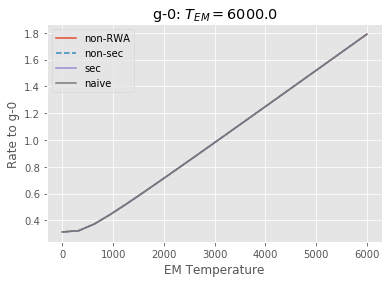

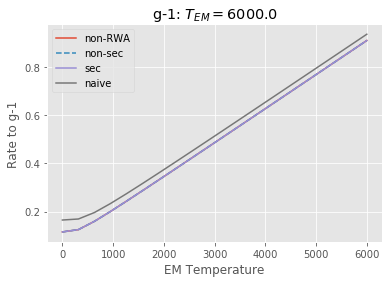

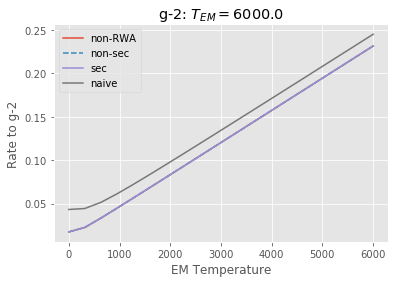

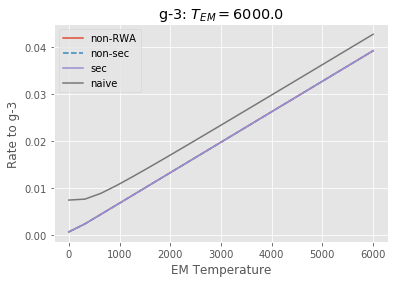

w_RC= 725.895  TLS splitting = 806.55 RC-res. bath coupling= 2.17980712105  N= 14 TLS-RC coupling= 303.258155236 Gamma_RC=  9941.95379292
It took  0.00285291671753  seconds to build the electronic-Lindblad Liouvillian
w_RC= 725.895  TLS splitting = 806.55 RC-res. bath coupling= 2.17980712105  N= 14 TLS-RC coupling= 303.258155236 Gamma_RC=  9941.95379292
It took  0.00268793106079  seconds to build the electronic-Lindblad Liouvillian
w_RC= 725.895  TLS splitting = 806.55 RC-res. bath coupling= 2.17980712105  N= 14 TLS-RC coupling= 303.258155236 Gamma_RC=  9941.95379292
It took  0.00276803970337  seconds to build the electronic-Lindblad Liouvillian
w_RC= 725.895  TLS splitting = 806.55 RC-res. bath coupling= 2.17980712105  N= 14 TLS-RC coupling= 303.258155236 Gamma_RC=  9941.95379292
It took  0.00265407562256  seconds to build the electronic-Lindblad Liouvillian
w_RC= 725.895  TLS splitting = 806.55 RC-res. bath coupling= 2.17980712105  N= 14 TLS-RC coupling= 303.258155236 Gamma_RC=  9941

KeyboardInterrupt: 

In [35]:
from qutip import vector_to_operator, operator_to_vector, basis


def decay_rate_plotter(eps, alpha_ph, w0, overdamped=True, nvib=3):
    T_array = np.linspace(0,6000,20)
    N = 14
    if overdamped:
        Gamma_ = w0**2/wc
    else:
        Gamma_ = 60.
        N = 24
    decay_wrt_T = [[],[],[],[]]
    labels = ['g-0',  'g-1', 'g-2','g-3', 'g-4', 'g-5']
    
    for T in T_array:
        L_RC, H, A_EM, A_nrwa, wRC, kappa, Gamma_1 = RC.RC_function_UD(sigma, eps, 300., Gamma_,
                                                                       w0, alpha_ph, N, silent=True)
    # given some Liouvillian, find the instantaneous decay rates
    # from e-0 to the ground manifold eigenstates, for several
    # oscillator displacements
    # - need to find the first eigenstate in the excited manifold
        evals, states = eigstate_calc_and_mag_sort(H, sort=False)
        ground_list = []
        excited_list = []
        for i in range(len(evals)): #
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        excited_ket = states[excited_list[0]]
        
        #initial_ket = tensor(basis(2,1), basis(N,0))
        excited_rho = excited_ket*excited_ket.dag()
        
        L= [EM.L_non_rwa(H, A_nrwa, eps, Gamma_EM, T, J=J_EM, silent=True), 
            EM.L_nonsecular(H, A_EM, eps, Gamma_EM, T, J=J_EM, silent=True),
            EM.L_vib_lindblad(H, A_EM, eps, Gamma_EM, T, J=J_EM, silent=True),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T, J=J_EM, silent=True)]
        for i_, L_EM in enumerate(L):
            decay_rates = [] # not really decay rates but population at short times
            for j in range(nvib):
                ground_ket = tensor(basis(2,0), basis(N,j))
                #print states[ground_list][j].dag()*target_ket
                #target_rho = operator_to_vector(target_ket*target_ket.dag())
                L_rho0_prod = vector_to_operator(L_EM*operator_to_vector(excited_ket*excited_ket.dag()))
                rate = L_rho0_prod.matrix_element(ground_ket.dag(), ground_ket)
                decay_rates.append(rate)
                
            if len(decay_rates)!=nvib:
                print ground_list
            decay_wrt_T[i_].append(decay_rates)
    for level in range(nvib):
        plt.figure()
        plt.title(labels[level]+r": $T_{EM}=$"+"{:0.1f}".format(T_EM))
        plt.plot(T_array,np.array(decay_wrt_T[0]).T[level], label='non-RWA')
        plt.plot(T_array,np.array(decay_wrt_T[1]).T[level], label='non-sec', linestyle='dashed')
        plt.plot(T_array,np.array(decay_wrt_T[2]).T[level], label='sec')
        plt.plot(T_array,np.array(decay_wrt_T[3]).T[level], label='naive')
        plt.legend()
        plt.xlabel('EM Temperature')
        plt.ylabel('Rate to {}'.format(labels[level]))
    plt.show()
    return T_array, decay_wrt_T
    #for i, alpha in enumerate(alpha_ph):
    #    plt.plot(decay_wrt_alpha[i])

_, _ = decay_rate_plotter(eps, 0.1*eps, eps*0.3, nvib=4)
_, _ = decay_rate_plotter(eps, 0.1*eps, eps*0.9, nvib=4)

#decay_rate_plotter(H_RC, L_ns)
#decay_rate_plotter(H_RC, L_n)

In [95]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', figsize=(12,8))
ax1.set_title

<bound method AxesSubplot.set_title of <matplotlib.axes._subplots.AxesSubplot object at 0x7f4bbcbe6a10>>

## Steady-state population of vibronic states: phonon coupling dependence

In [137]:
def steadystatePop_coupling_dependence(prop_couplings, T_ph, eps, Gamma, w0, T_EM, 
                                    Gamma_EM, overdamped=True):
    
    if overdamped:
        Gamma = w0**2/wc
    plt.figure()
    N = 14
    G = ket([0])
    E = ket([1])
    sigma = G*E.dag() # Definition of a sigma_- operator.
    J = EM.J_minimal
    count = 1.

    data_nrwa  = [[],[],[],[],[],[],[]]
    data_ns    = [[],[],[],[],[],[],[]]
    data_s     = [[],[],[],[],[],[],[]]
    data_n     = [[],[],[],[],[],[],[]]
    labels = ['g-0',  'g-1', 'g-2','e-0','e-1', 'e-2'] 
    # This is true for specific Hamiltonian parameters
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    I_RC = qt.qeye(N)
    print "RC freq. prop = $", w0/eps
    for prop in prop_couplings:
        alpha_ph = prop*eps
        if count ==1 or count%5==0:
            print "{:0.2f}% finished".format((count/len(prop_couplings))*100)
        count+=1
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                       T_ph, Gamma, 
                                                                       w0, alpha_ph, N,
                                                                       silent=True)
        evals, states = eigstate_calc_and_mag_sort(H_RC, sort=False)
        ground_list = []
        excited_list = []
        for i in range(2*N): #
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        lowest_6 = [s*s.dag() for s in states[ground_list[0:3] + excited_list[0:3]]]
        lowest_6.append(tensor(E*E.dag(), I_RC))
        #print len(excited_list), 'excited'
        # electromagnetic bath liouvillians
        L_nrwa = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J, silent=True)
        L_ns = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
        L_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
        L_n = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J, silent=True)
        for j, obs in enumerate(lowest_6):
            method = 'iterative-lgmres'
            data_nrwa[j].append((obs*steadystate(H_RC, [L_RC+L_nrwa])).tr())
            data_ns[j].append((obs*steadystate(H_RC, [L_RC+L_ns])).tr())
            data_s[j].append((obs*steadystate(H_RC, [L_RC+L_s])).tr())
            data_n[j].append((obs*steadystate(H_RC, [L_RC+L_n])).tr())
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex='col', figsize=(14,8))
    axes = [eval("ax{}".format(i)) for i in range(1,7)]
    for i, lab in enumerate(labels):
        axes[i].set_title(lab)
        axes[i].plot(prop_couplings, data_nrwa[i], label='nrwa')
        axes[i].plot(prop_couplings, data_ns[i], label='ns', linestyle='dashed')
        axes[i].plot(prop_couplings, data_s[i], label='s')
        axes[i].plot(prop_couplings, data_n[i], label='n')
        #plt.grid()
        axes[i].set(xlabel=r"Phonon Coupling Strength: units of $\epsilon$", 
               ylabel="Population")
        axes[i].label_outer()
    plt.legend()
    plt.figure()
    plt.title("Excited state")
    plt.plot(prop_couplings, data_nrwa[-1], label='nrwa')
    plt.plot(prop_couplings, data_ns[-1], label='ns', linestyle='dashed')
    plt.plot(prop_couplings, data_s[-1], label='s')
    plt.plot(prop_couplings, data_n[-1], label='n')
    plt.legend()
    plt.ylabel("Population")
    plt.xlabel(r"Phonon Coupling Strength: units of $\epsilon$")
    plt.show()

RC freq. prop = $ 0.1
2.22% finished
11.11% finished
22.22% finished
33.33% finished
44.44% finished
55.56% finished
66.67% finished
77.78% finished
88.89% finished
100.00% finished


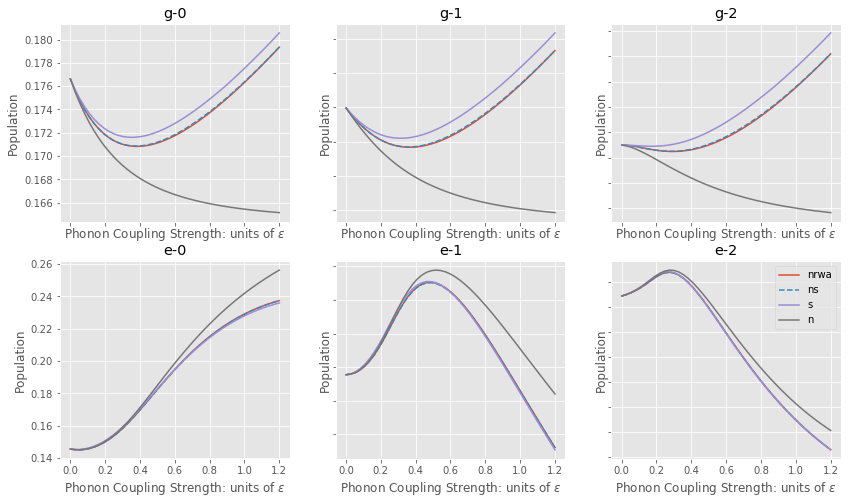

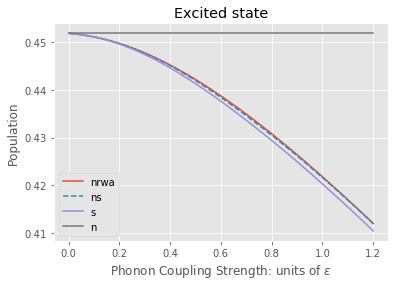

RC freq. prop = $ 0.4
2.22% finished
11.11% finished
22.22% finished
33.33% finished
44.44% finished
55.56% finished
66.67% finished
77.78% finished
88.89% finished
100.00% finished


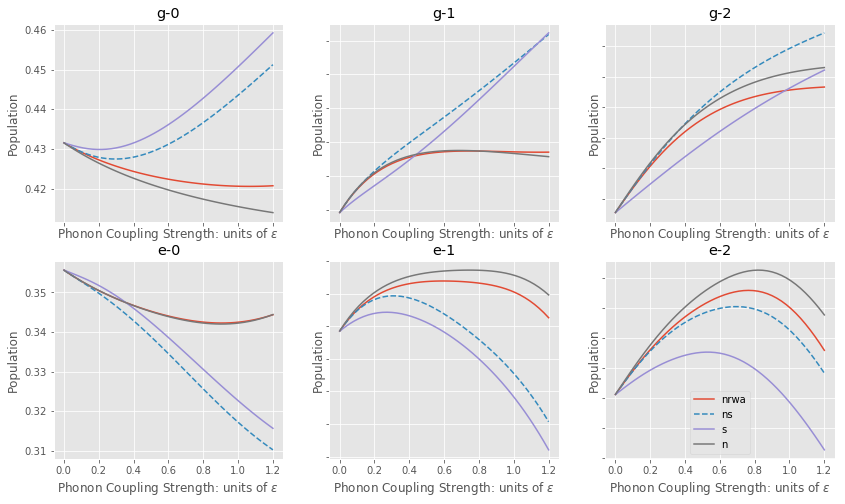

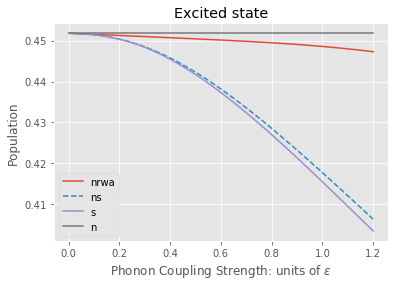

RC freq. prop = $ 0.9
2.22% finished
11.11% finished
22.22% finished
33.33% finished
44.44% finished
55.56% finished
66.67% finished
77.78% finished
88.89% finished
100.00% finished


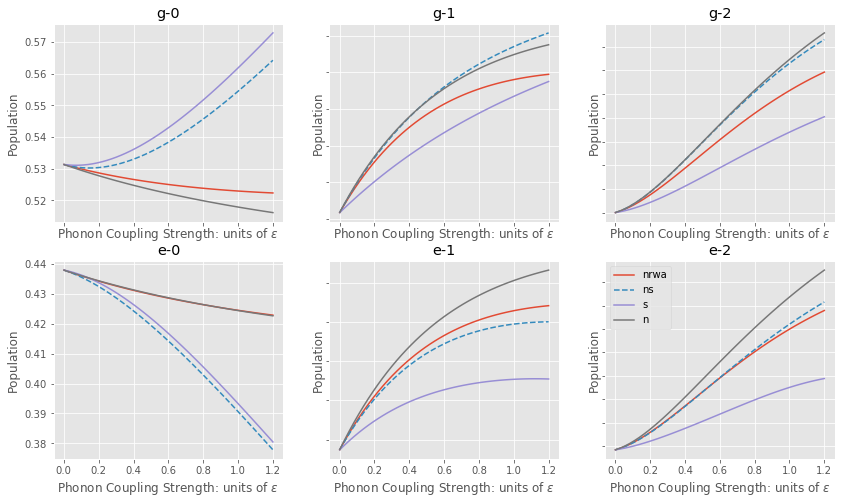

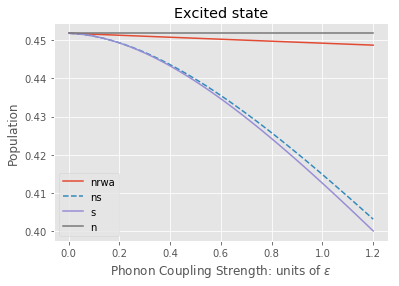

RC freq. prop = $ 1.5
2.22% finished
11.11% finished
22.22% finished
33.33% finished
44.44% finished
55.56% finished
66.67% finished
77.78% finished
88.89% finished
100.00% finished


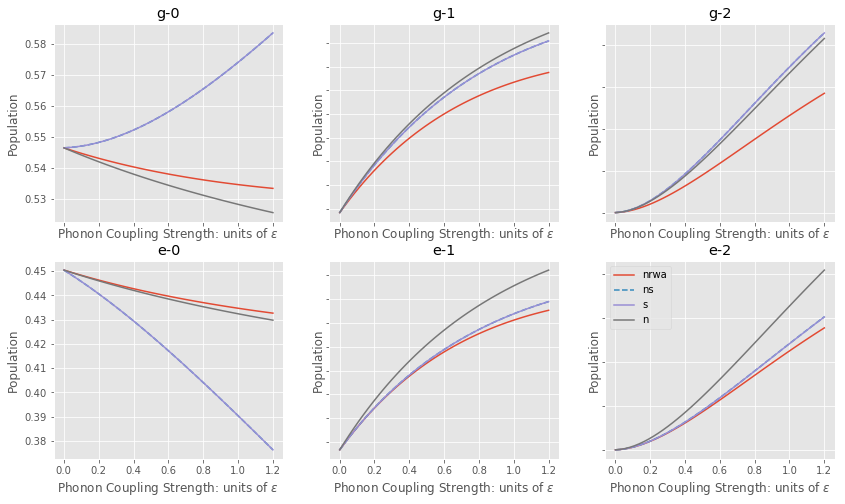

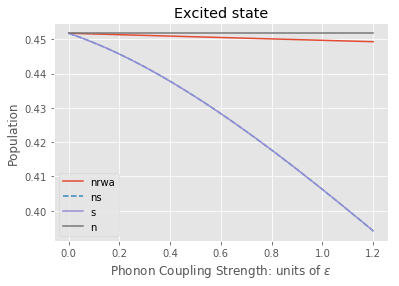

RC freq. prop = $ 3.0
2.22% finished
11.11% finished
22.22% finished
33.33% finished
44.44% finished
55.56% finished
66.67% finished
77.78% finished
88.89% finished
100.00% finished


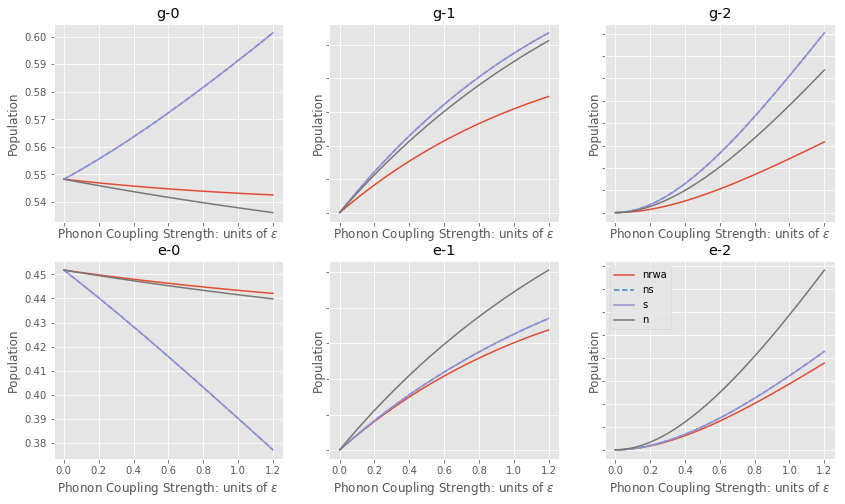

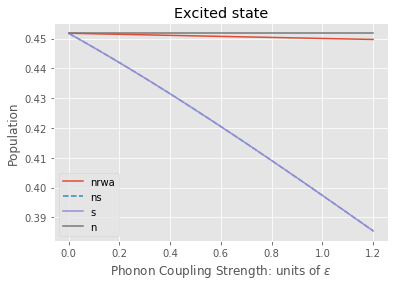

In [138]:
couplings = np.linspace(0.001,1.2,45)
steadystatePop_coupling_dependence(couplings, T_ph, eps, 60, 0.1*eps, 
                                T_EM, Gamma_EM, overdamped=False)
steadystatePop_coupling_dependence(couplings, T_ph, eps, Gamma, 0.4*eps, 
                                T_EM, Gamma_EM, overdamped=True)
steadystatePop_coupling_dependence(couplings, T_ph, eps, Gamma, 0.9*eps, 
                                T_EM, Gamma_EM, overdamped=True)
steadystatePop_coupling_dependence(couplings, T_ph, eps, 60, 1.5*eps, 
                                T_EM, Gamma_EM, overdamped=False)
steadystatePop_coupling_dependence(couplings, T_ph, eps, 60, 3.*eps, 
                                T_EM, Gamma_EM, overdamped=False)

As w0 gets larger, the vibronic dynamics change drastically but the overall electronic levels do not.

## Dynamics of Vibronic States
Should be able to see the vibronic states being occupied, even if the rates are initially zero?

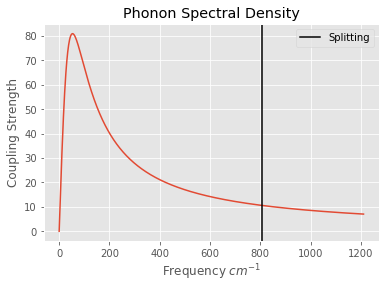

w_RC= 887.205  TLS splitting = 806.55 RC-res. bath coupling= 2.66420870351  N= 10 TLS-RC coupling= 474.135610204 Gamma_RC=  14851.5606042
Calculating non-RWA Liouvilliian took 0.223706960678 seconds.
It took  0.340162992477  seconds to build the Non-secular RWA Liouvillian
It took  0.00261306762695  seconds to build the electronic-Lindblad Liouvillian
Completed dynamics calculation 1 in 21.3969898224 seconds.
Completed dynamics calculation 2 in 15.4511041641 seconds.
Completed dynamics calculation 3 in 15.3444809914 seconds.


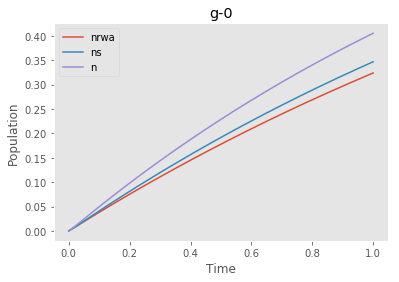

g-0 state accounts for
NRWA: 48.9178%
NS: 54.3098%
Naive: 69.9129% of total dynamics


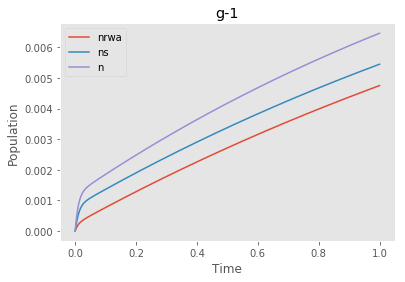

g-1 state accounts for
NRWA: 0.7176%
NS: 0.8532%
Naive: 1.1146% of total dynamics


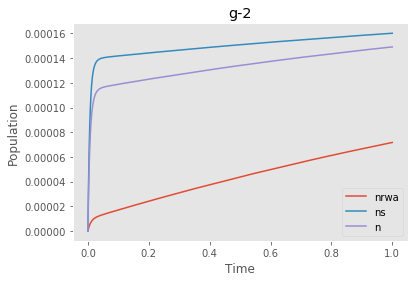

g-2 state accounts for
NRWA: 0.0108%
NS: 0.0251%
Naive: 0.0257% of total dynamics


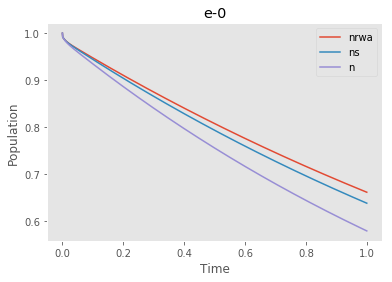

e-0 state accounts for
NRWA: 100.0000%
NS: 100.0000%
Naive: 100.0000% of total dynamics


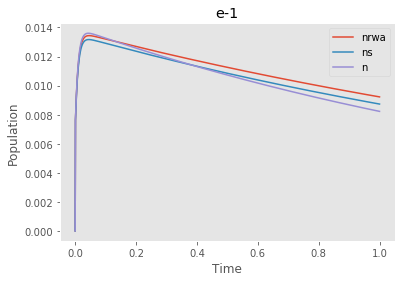

e-1 state accounts for
NRWA: 1.3933%
NS: 1.3670%
Naive: 1.4191% of total dynamics


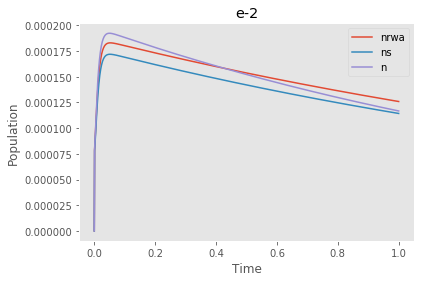

e-2 state accounts for
NRWA: 0.0190%
NS: 0.0179%
Naive: 0.0201% of total dynamics


In [38]:
def vibronic_state_dynamics(init_sys, init_RC, prop_coupling, eps, Gamma, w0, T_ph=300., T_EM=6000., 
                                    Gamma_EM=1., overdamped=True):
    # Start system+RC in adiabatic eigenstate and then time-evolve
    alpha_ph = prop_coupling*eps

    if overdamped:
        w0 = eps*1.1
        Gamma = w0**2/wc
    
    w = np.linspace(0., eps*1.5, 1000)
    plt.figure()
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma, w0))
    plt.axvline(eps, label='Splitting',color='k')
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    plt.show()
    
    N = 10
    G = ket([0])
    E = ket([1])
    
    sigma = G*E.dag() # Definition of a sigma_- operator.
    J = EM.J_minimal
    count = 1
    
    labels = ['g-0',  'g-1', 'g-2','e-0','e-1', 'e-2'] 
    # This is true for specific Hamiltonian parameters
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dyn_DATA = []
    
    L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                   T_ph, Gamma, 
                                                                   w0, alpha_ph, N)
    evals, states = H_RC.eigenstates()
    ground_list = []
    excited_list = []
    for i in range(len(evals)): #
        is_ground = sum(states[i])[0][0].real == 1.
        if is_ground:
            ground_list.append(i)
        else:
            excited_list.append(i)
    
    if init_sys == 0:
        init_ket = states[ground_list[init_RC]]
    else:
        init_ket = states[excited_list[init_RC]]
    init_rho = init_ket*init_ket.dag()    
    expects_vib = [s*s.dag() for s in states[ground_list[0:3] + excited_list[0:3]]]
    #print len(excited_list), 'excited'
    # electromagnetic bath liouvillians
    L_nrwa = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J)
    L_ns = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J)
    #L_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J)
    L_n = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J)
    Liouvs = [L_nrwa, L_ns, L_n]
    timelist = np.linspace(0,1.,1000)
    for L_EM in Liouvs:
        ti = time.time()
        dyn_DATA.append(mesolve(H_RC, init_rho, timelist, [L_RC+L_EM], expects_vib))
        print "Completed dynamics calculation {} in {} seconds.".format(Liouvs.index(L_EM)+1, time.time()-ti)
        
    for i, lab in enumerate(labels):
        plt.figure()
        
        init_state_final_pop_0 = dyn_DATA[0].expect[(3*init_sys+init_RC)][-1]
        init_state_final_pop_1 = dyn_DATA[1].expect[(3*init_sys+init_RC)][-1]
        init_state_final_pop_2 = dyn_DATA[2].expect[(3*init_sys+init_RC)][-1]
        
        plt.title(lab)
        plt.plot(timelist, dyn_DATA[0].expect[i], label='nrwa')
        plt.plot(timelist, dyn_DATA[1].expect[i], label='ns')
        plt.plot(timelist, dyn_DATA[2].expect[i], label='n')
        
        plt.legend()
        plt.grid()
        plt.ylabel("Population")
        plt.xlabel(r"Time")
        plt.show()
        print "{} state accounts for".format(lab)
        print "NRWA: {:0.4f}%".format(100*(dyn_DATA[0].expect[i][-1]/init_state_final_pop_0))
        print "NS: {:0.4f}%" .format(100*(dyn_DATA[1].expect[i][-1]/init_state_final_pop_1))
        print "Naive: {:0.4f}% of total dynamics".format(100*(dyn_DATA[2].expect[i][-1]/init_state_final_pop_2))

vibronic_state_dynamics(1, 0, 0.2, eps, 0., 0., T_ph=300., T_EM=0., 
                                    Gamma_EM=Gamma_EM, overdamped=True)